In [31]:
import os
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf

print(f"FloPy version: {flopy.__version__}")

FloPy version: 3.9.5


In [32]:
# File paths
model_top_dir = "../HW_2"
input_dir = os.path.join(model_top_dir, "Troubleshoot")
if not os.path.exists(input_dir):
    print("Creating workspace directory")
    os.makedirs(input_dir, exist_ok=True)

main_name = "Wildcat_main"

wildcat = os.path.join(input_dir, main_name)
if not os.path.exists(wildcat):
    print("Creating workspace directory")
    os.makedirs(wildcat, exist_ok=True)

exe_name = "../../../../modflow/mf2005"   # MF2005 executable
assert os.path.exists(exe_name), f"mf2005 not found at: {exe_name}"

In [33]:
# DIS
Lx = 2500.0                 # meters
Ly = 2500.0                 # meters
dx = dy = 50.0             # cell width in meters
nrow = ncol = int(Lx / dx)  # Number of rows and columns

nlay = 1
ztop = 250.0
zbot = 0.0
dz   = (ztop - zbot) / nlay

nper   = 1
perlen = [1.0]
nstp   = [1]
steady = [True]
itmuni = 4                  # Days
lenuni = 2                  # Meters

# LPF
n  = 0.35
Sy = 0.30
Ss = 0.001
laytyp = 1                  # 0 = confined, 1 convertible/unconfined

# BAS
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:,:,0]  = -1          #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1         #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 

print(f"Rows = nrow\nCols = {ncol}")

Rows = nrow
Cols = 50


In [34]:
# Heads
strt = np.ones((nlay, nrow,ncol), dtype=np.float32)
strt[:, :, 0] = dz - 5
strt[:, :, -1] = dz - 50

print(f"Heads West: {strt[:, 0, 0]}\nHeads East: {strt[:, 0, -1]}")

Heads West: [245.]
Heads East: [200.]


In [35]:
acre_to_m2 = 4046.8564

obs = [
    {"name":"OW1", "y":3130, "x":806,  "dtw":4.8,  "K":1.5},
    {"name":"OW2", "y":774,  "x":750,  "dtw":5.4,  "K":13.0},
    {"name":"OW3", "y":3063, "x":3102, "dtw":50.2, "K":1.0},
    {"name":"OW4", "y":772,  "x":3250, "dtw":51.6, "K":8.4},
]

for o in obs:
    o["head"] = ztop - o["dtw"]


# Pumping rates (m3/day) confirmed
Q_wild = 348.0784                   # m^3/day
Q_acme_total = 10462.0663           # m^3/day
Q_acme_each = Q_acme_total / 2.0
Q_total = Q_wild + Q_acme_total


In [36]:
# Wells
r_mid = nrow // 2
c_mid = ncol // 2
layer = 0
wel_data_sp0 = [[layer, r_mid, c_mid, -Q_wild], [layer, r_mid-0.1*nrow//dy, 8*ncol//dx, -Q_acme_each], [layer, r_mid-0.1*nrow//dy, ncol-8*ncol//dx, -Q_acme_each]]

print(wel_data_sp0)

[[0, 25, 25, -348.0784], [0, 25.0, 8.0, -5231.03315], [0, 25.0, 42.0, -5231.03315]]


In [37]:
#K
hk = np.zeros((nlay, nrow, ncol), dtype=np.float32)
# hk[:, :r_mid, :c_mid] = obs[0]["K"]      # upper left
# hk[:, :r_mid, c_mid:] = obs[2]["K"]      # upper right
# hk[:, r_mid:, :c_mid] = obs[1]["K"]      # lower left
# hk[:, r_mid:, c_mid:] = obs[3]["K"]      # lower right
hk[:,:,:] = 1

In [38]:
# Recharge
R_background = 1e-4
rech = np.full((nlay, nrow, ncol), R_background, dtype=float)
cell_area = dx * dy
active2d = (ibound[:, :] > 0)  # Active Cells (not including BC cells)
rech_total = np.sum(rech[active2d] * cell_area)
print(f"Recharge per cell: {rech[0,0,0]}\nTotal Active Cells: {cell_area}\nTotal Recharge: {rech_total}")

Recharge per cell: 0.0001
Total Active Cells: 2500.0
Total Recharge: 600.0


In [39]:
# Build Model
m   = flopy.modflow.Modflow(modelname=main_name, model_ws=wildcat, exe_name=exe_name, version="mf2005")
DIS = flopy.modflow.ModflowDis( model=m, nlay=nlay, nrow=nrow, ncol=ncol, delr=dx, delc=dy, top=ztop, botm=zbot, itmuni = 4, lenuni = 2, nper=nper, steady=steady)
BAS = flopy.modflow.ModflowBas(model=m, ibound=ibound, strt=strt)
LPF = flopy.modflow.ModflowLpf(model=m, ipakcb=53, laytyp=laytyp, hk=hk, vka=1, ss=Ss, sy=Sy)
RCH = flopy.modflow.ModflowRch(model=m, rech=rech, nrchop=3, ipakcb=53)
WEL = flopy.modflow.ModflowWel(model=m, stress_period_data={0: wel_data_sp0})
PCG = flopy.modflow.ModflowPcg(model=m)
OC  = flopy.modflow.ModflowOc(model=m, stress_period_data={(0,0):['print head', 'print budget', 'save head', 'save budget']}, compact=True)

# Check the default key~value arguments for any package
import inspect
print(inspect.signature(flopy.modflow.ModflowLpf))

m.write_input()


(model, laytyp=0, layavg=0, chani=1.0, layvka=0, laywet=0, ipakcb=None, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, hk=1.0, hani=1.0, vka=1.0, ss=1e-05, sy=0.15, vkcb=0.0, wetdry=-0.01, storagecoefficient=False, constantcv=False, thickstrt=False, nocvcorrection=False, novfc=False, extension='lpf', unitnumber=None, filenames=None, add_package=True)


In [40]:
success, buff = m.run_model(silent=False, report=True)
print("Run success:", success)

if not success:
    print("\n--- MODFLOW FAILED ---")

FloPy is using the following executable to run the model: ../../../../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: Wildcat_main.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/10 21:09:06

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/10 21:09:06
 Elapsed run time:  0.024 Seconds

  Normal termination of simulation
Run success: True


In [41]:
def plot_map(fig, ax, model, array2d=None, title="", cmap="viridis", cbar_label=None, layer=0, plot_grid=False, alpha=0.85, clim=None):
    modelmap = flopy.plot.PlotMapView(model=model, ax=ax, layer=layer)
    if plot_grid:
        modelmap.plot_grid(linewidth=0.2)

    plot_kwargs = {"cmap": cmap, "alpha": alpha}
    if clim is not None:
        plot_kwargs["vmin"], plot_kwargs["vmax"] = clim
    im = modelmap.plot_array(array2d, **plot_kwargs)

    fig.colorbar(im, ax=ax, shrink=0.7, label=cbar_label)

    ax.set_title(title)
    ax.set_aspect("equal", adjustable="box")
    return im

In [42]:
def base_map(ax, model, title="Base Map", plot_grid=True, base=True):
    modelmap = flopy.plot.PlotMapView(model=model, ax=ax, layer=0)
    if plot_grid:
        modelmap.plot_grid(linewidth=0.2)

    if base:
        modelmap.plot_ibound()
        wel = modelmap.plot_bc(ftype='WEL')
        ibound_handles = [mp.patches.Patch(facecolor="blue",  edgecolor="black", label="Const. Head"),
                          mp.patches.Patch(facecolor="white", edgecolor="black", label="Active Cell"),
                          mp.patches.Patch(facecolor="red", edgecolor="red", label="Well")]

    ax.set_title(title)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)

    leg1 = ax.legend(loc="upper right", frameon=True)
    if base:
        leg2 = ax.legend(handles=ibound_handles, loc="upper center", frameon=True, ncol=3)
        ax.add_artist(leg1)

    ax.set_aspect("equal", adjustable="box")
    return modelmap

/tmp/ipykernel_6860/3448112735.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  leg1 = ax.legend(loc="upper right", frameon=True)


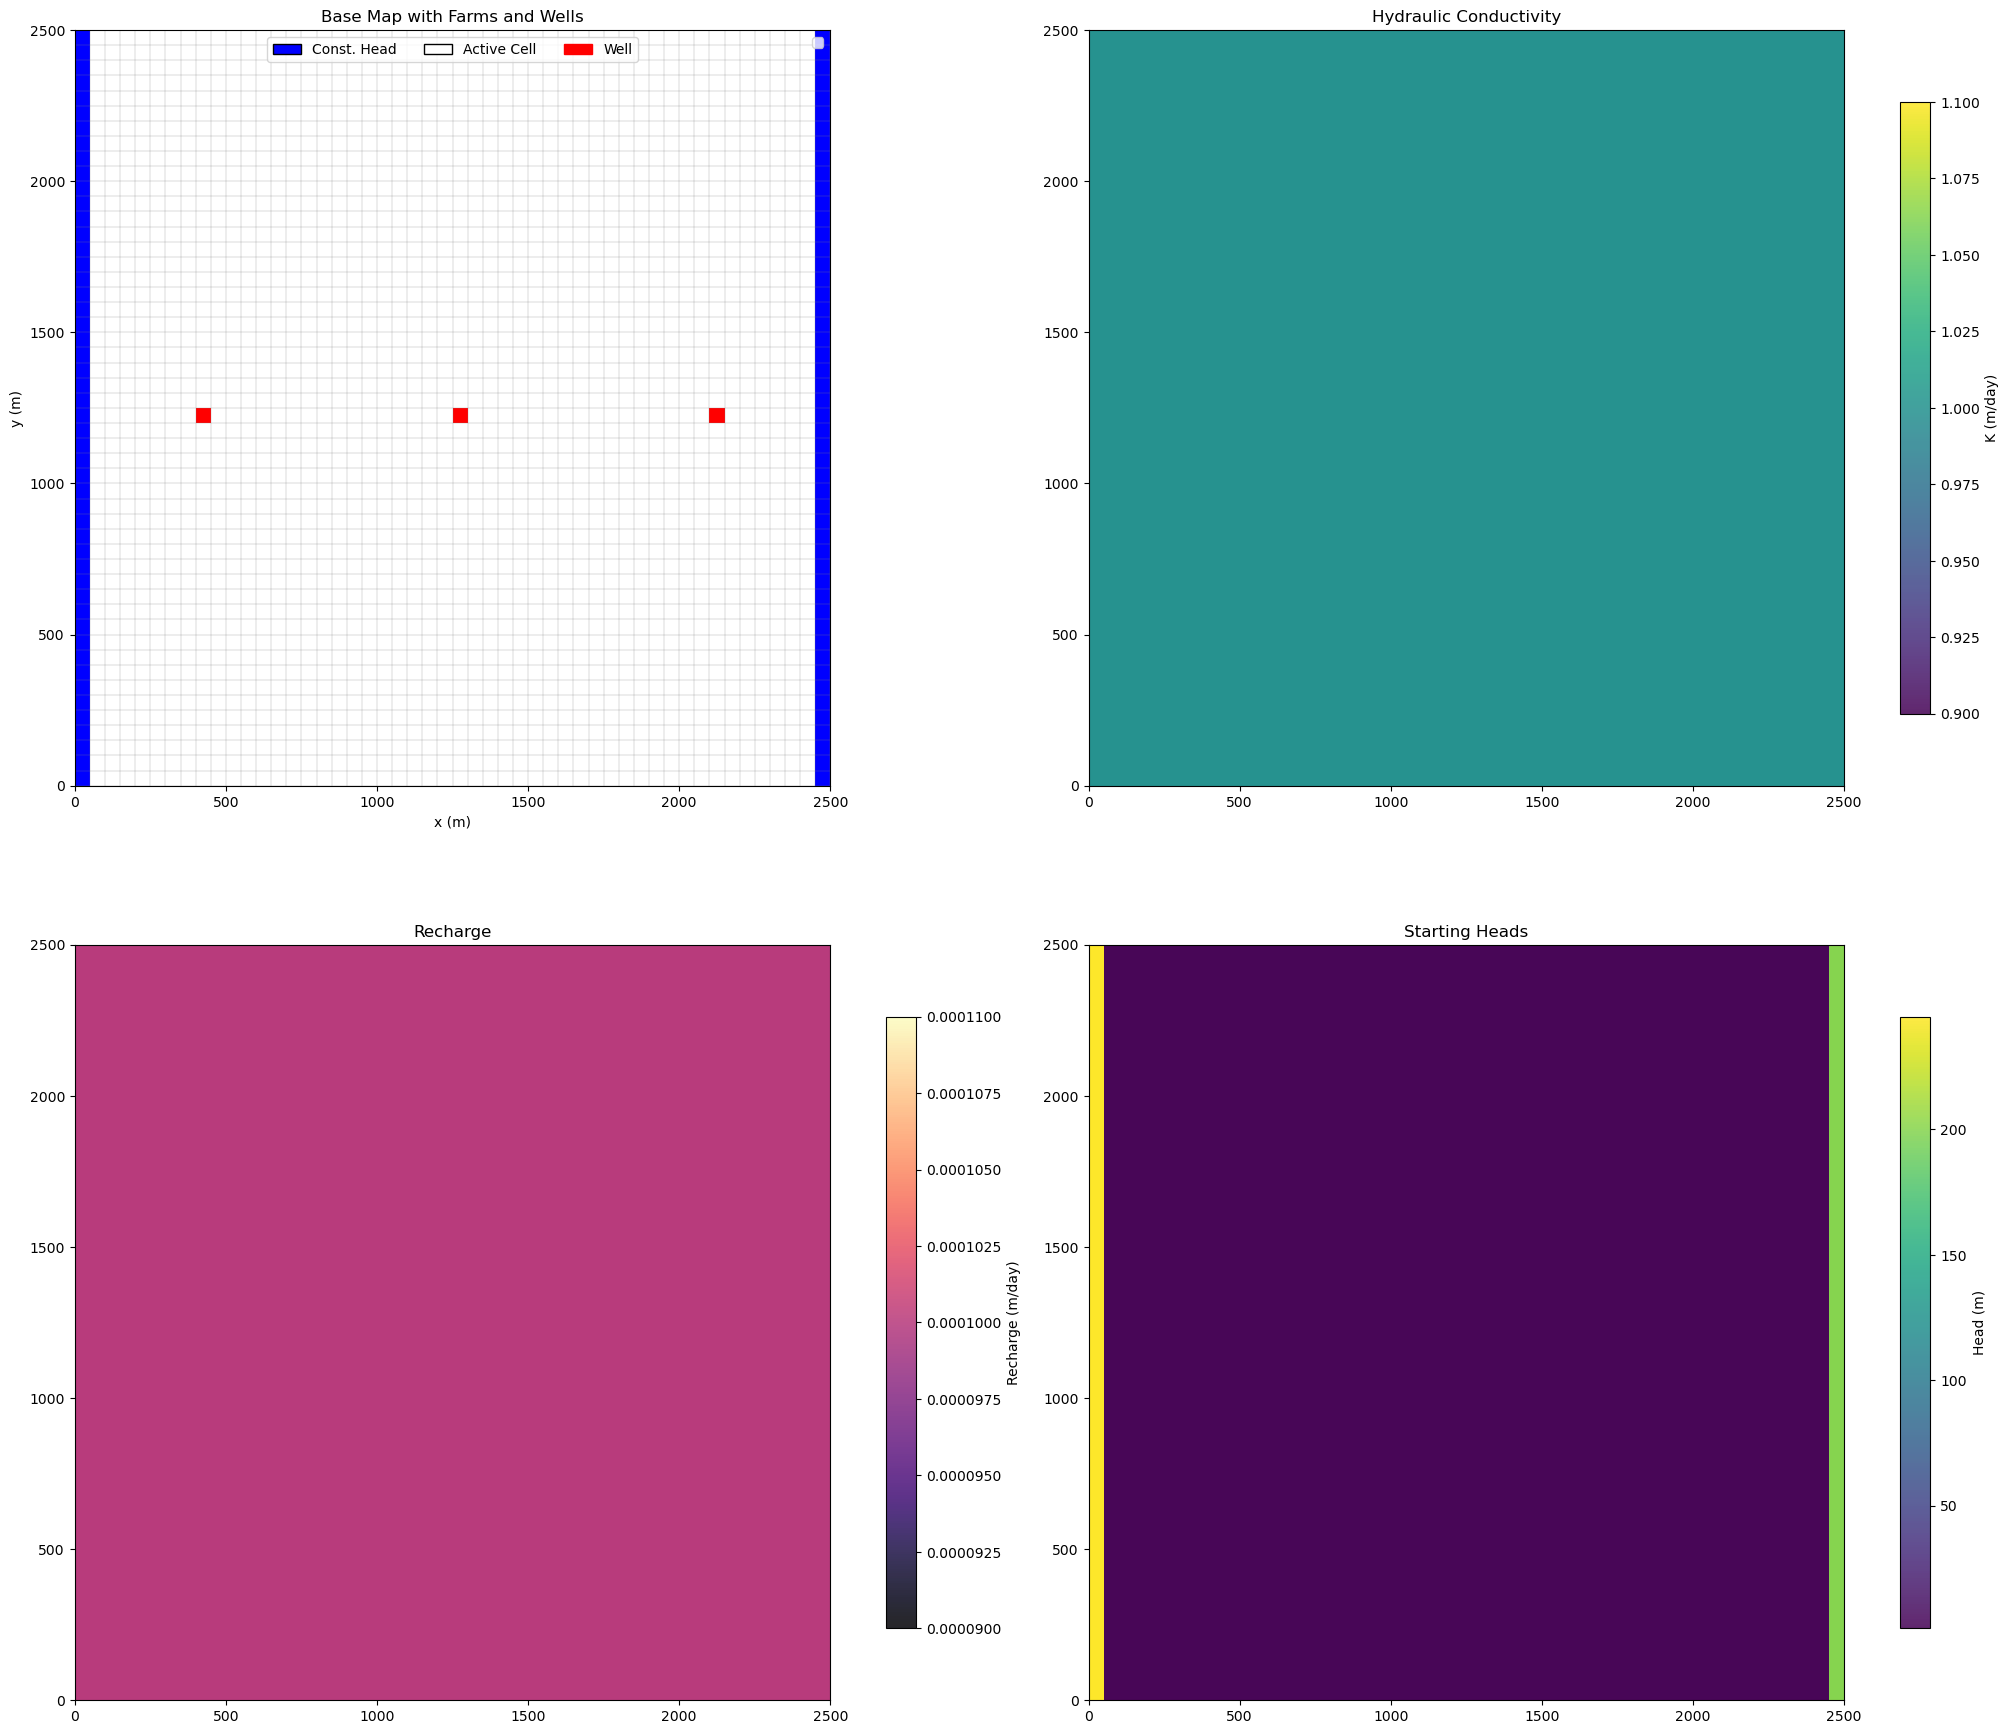

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(20, 18), constrained_layout=True, squeeze=False)
ax1, ax2 = axs[0]
ax3, ax4 = axs[1]

titles = ("Base Map with Farms and Wells", "Recharge", "Hydraulic Conductivity", "Starting Heads")
cbars  = ("Recharge (m/day)", "K (m/day)", "Head (m)")

# Base map goes on ax1
base_map(ax1, m, title=titles[0], plot_grid=True)

# Array plots
plot_map(fig, ax2, m, array2d=hk,   title=titles[2], cbar_label=cbars[1], plot_grid=False)
plot_map(fig, ax3, m, array2d=rech, title=titles[1], cmap="magma", cbar_label=cbars[0], plot_grid=False)
plot_map(fig, ax4, m, array2d=strt, title=titles[3], cbar_label=cbars[2], plot_grid=False)

# Set extents consistently (since you did not share axes)
for ax in (ax1, ax2, ax3, ax4):
    ax.set_xlim(0, Lx)
    ax.set_ylim(0, Ly)
    ax.set_aspect("equal", adjustable="box")

plt.show()


In [44]:
#  /workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/1_Analysis/HW_2/Troubleshoot
#  /workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/1_Analysis/HW_2/Troubleshoot/Wildcat_main/Wildcat_main.hds
model_path = os.path.join("/workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/1_Analysis/HW_2/Troubleshoot", "Wildcat_main/Wildcat_main")
print(model_path)
if not os.path.exists(model_path + ".hds"):
    print("Heads file not found:", model_path)

hds = flopy.utils.HeadFile(model_path + ".hds")
head = hds.get_data(kstpkper=(0, 0))   # shape (nlay,nrow,ncol) or (nrow,ncol)
# ensure 2D for plotting
if head.ndim == 3:
    head = head[0, :, :]
else:
    print("Potential in head")   # maybe make this a try - except check


/workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/1_Analysis/HW_2/Troubleshoot/Wildcat_main/Wildcat_main


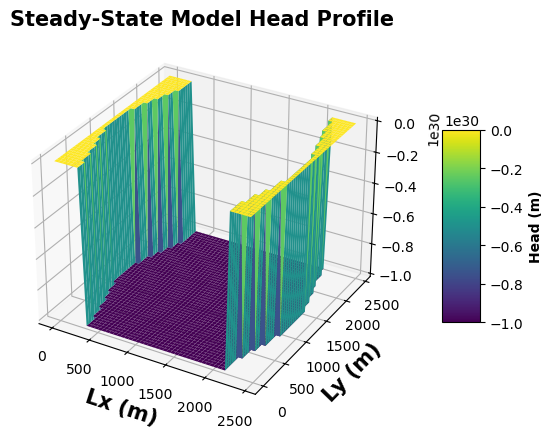

In [45]:

headobj = bf.HeadFile(model_path + ".hds")                  #reads the binary head file
times = headobj.get_times()                                 #returns a list of timesteps
head = headobj.get_data(totim=times[-1])                    #returns a numpy array of heads for specified time (last timestep)

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.add_subplot(111,projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0, Lx, dx)
Y = np.arange(0, Ly, dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, label='head')
fig_3d.colorbar(surf, shrink=0.5,aspect=5).set_label('Head (m)', fontsize=10, fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
plt.show(surf)

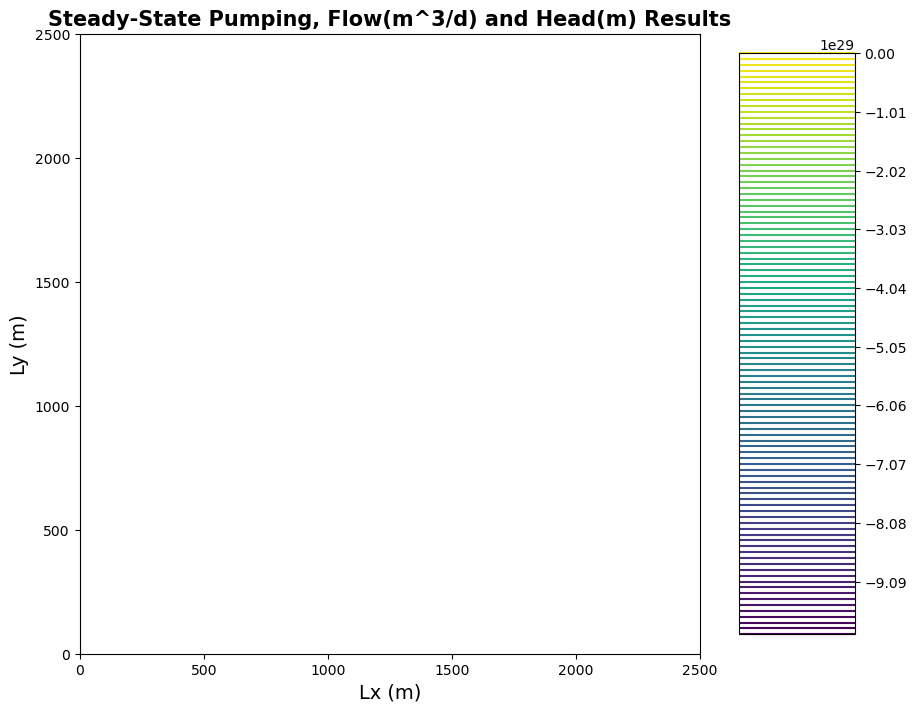

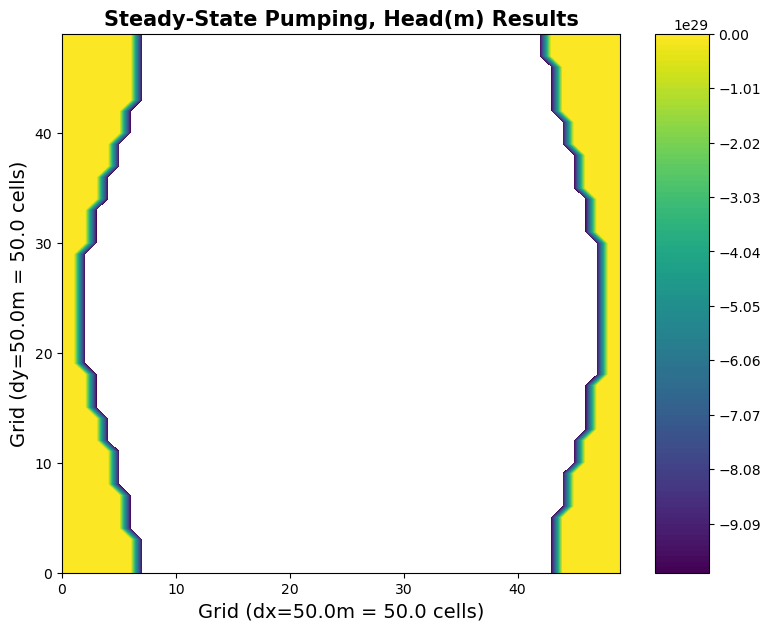

In [46]:
#plot results
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
# grid = modelmap.plot_grid() #plot model grid
contour_levels = np.linspace(head[0].min(),head[0].max(),100) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours

plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Pumping, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours, aspect=5)
plt.show(modelmap)

#create plot
plt.figure(figsize=(9,7))
cf = plt.contourf(np.flipud(head[0,:,:]),levels=contour_levels)

plt.xlabel(f'Grid (dx={dx}m = {Lx/dx} cells)',fontsize = 14)
plt.ylabel(f'Grid (dy={dy}m = {Ly/dy} cells)',fontsize = 14)
plt.title('Steady-State Pumping, Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(cf,aspect=10)
plt.show()

/workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/1_Analysis/HW_2/Troubleshoot/Wildcat_main/Wildcat_main


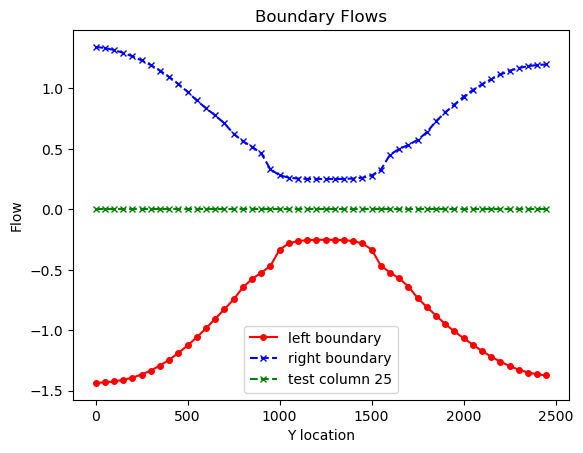

Left Flux = -43.499996 
Right_flux = 38.25
Difference = 81.75
Pumping = 10810.1447
Recharge = 600.00
∆Storage = -10128.39 ... Not Steady State :(


In [47]:
print(model_path)
budgobj = bf.CellBudgetFile(model_path +'.cbc')

kstpkper_list = budgobj.get_kstpkper()                      # returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0)   # returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0)   # returns an array of flow rates for front face of cells     
                                                            # string options are in the list file under output control (make sure to include spaces!)
test_col = c_mid   #  This will need to change if you change your dx
flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]
test = flux_vals[:,test_col]


bdryflux_fig = plt.figure() 
x=np.arange(0,ncol*dx,dx) 
plt.plot(x,leftflux,marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(x,rightflux,marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.plot(x,test,marker='x', color='green', markersize=4, linestyle='--',label=f"test column {test_col}")

plt.xlabel('Y location')
plt.ylabel('Flow')
plt.title("Boundary Flows")
plt.legend()
plt.show()

# Calculate the total flux across the right and left side of the domain 
# See that the difference matches the pumping rate
right_tot = np.sum(rightflux)   # Note the units of this are L3/T
left_tot = np.sum(leftflux)

# Calculate the total flux across the right and left side of the domain 
# See that the difference matches the pumping rate
right_tot = np.sum(rightflux)   # Note the units of this are L3/T
left_tot = np.sum(leftflux)

difference = right_tot-left_tot
delta = Q_total - abs(difference)
storage = rech_total - delta
print('Left Flux =', left_tot, "\nRight_flux =", right_tot)
print(f"Difference = {difference}\nPumping = {Q_total}\nRecharge = {rech_total:.2f}")
print(f"∆Storage = {storage:.2f} ... Steady State!!!" if abs(storage) <= 1 else f"∆Storage = {storage:.2f} ... Not Steady State :(")


